In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
from builtins import *
from io import open

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from patsy import dmatrix, dmatrices, EvalEnvironment, ModelDesc, INTERCEPT

sns.set_context("paper")
sns.set_style("ticks")

from collections import Counter
import re

In [2]:
df = pd.read_csv("data/export_papers_964.txt?sequence=5", sep="\t")
print(df.shape)

(49043, 20)


In [3]:
df.head()

,AUID,PMID,Position,Year,Title,Authors,Journal,Volume,Issue,Pages,Last Name,First Name,Affiliation,City,State,Country,Institute type,Latitude,Longitude,Mesh Terms
0,101462_4,18729633,4,2008,Effects of chronic estradiol treatment on dela...,14600290_2|15353173_1|9020311_1|101462_4|51783...,Behav Neurosci,122,4,794-804,Allred,Clinton,-,-,-,-,-,-,-,"Analysis of Variance|Animals|Behavior, Animal|..."
1,101462_4,18203887,1,2008,PPARgamma1 as a molecular target of eicosapent...,101462_4|17453334_1|10601471_2|12242035_1|2430...,J Nutr,138,2,250-6,Allred,Clinton,"Department of Nutrition and Food Science, Texa...","College Station, TX, USA",TX,USA,EDU,30.621,-96.326,Anilides|Cell Proliferation|Colonic Neoplasms|...
2,101462_4,18057390,6,2008,Effect of posterior cruciate ligament deficien...,8707798_2|15701610_2|18057390_3|16813450_1|165...,Am J Sports Med,36,3,474-9,Allred,Dain,-,-,-,-,-,-,-,Adult|Case-Control Studies|Female|Humans|Knee ...
3,101462_4,17902047,3,2008,MAZ drives tumor-specific expression of PPAR g...,12242035_1|10601471_2|101462_4|17453334_1|1002...,Breast Cancer Res Treat,111,1,103-11,Allred,Clinton,FROMPMC: Department of Molecular and Biomedica...,"Lexington, KY, USA",KY,USA,EDU,38.049,-84.5,"Blotting, Western|Breast Neoplasms|Cell Line, ..."
4,101462_4,17453334,2,2008,Transactivation of ERalpha by Rosiglitazone in...,17453334_1|101462_4|17453334_3|2430908_1,Breast Cancer Res Treat,108,1,23-33,Allred,Clinton,-,-,-,-,-,-,-,"Blotting, Western|Breast Neoplasms|Cell Line, ..."


In [4]:
df.columns

Index([u'AUID', u'PMID', u'Position', u'Year', u'Title', u'Authors',
       u'Journal', u'Volume', u'Issue', u'Pages', u'Last Name', u'First Name',
       u'Affiliation', u'City', u'State', u'Country', u'Institute type',
       u'Latitude', u'Longitude', u'Mesh Terms'],
      dtype='object')

In [5]:
df_filtered = df.ix[(df.Latitude != "-") & (df.Year != "-"), ["AUID", "City", "Year", "Latitude", "Longitude", "Position"]].copy()
df_filtered.Year = df_filtered.Year.astype("int")
df_filtered.head()

,AUID,City,Year,Latitude,Longitude,Position
1,101462_4,"College Station, TX, USA",2008,30.621,-96.326,1
3,101462_4,"Lexington, KY, USA",2008,38.049,-84.5,3
7,101462_4,"Urbana-Champaign, IL, USA",2005,40.115,-88.193,1
8,101462_4,"Lexington, KY, USA",2005,38.049,-84.5,1
9,101462_4,"Urbana-Champaign, IL, USA",2004,40.115,-88.193,1


In [6]:
df_filtered["Weight"] = df["Affiliation"].str.contains("FROMPMC").apply(lambda x: 1 if x else 3)
df_filtered.head()

,AUID,City,Year,Latitude,Longitude,Position,Weight
1,101462_4,"College Station, TX, USA",2008,30.621,-96.326,1,3
3,101462_4,"Lexington, KY, USA",2008,38.049,-84.5,3,1
7,101462_4,"Urbana-Champaign, IL, USA",2005,40.115,-88.193,1,3
8,101462_4,"Lexington, KY, USA",2005,38.049,-84.5,1,3
9,101462_4,"Urbana-Champaign, IL, USA",2004,40.115,-88.193,1,3


In [7]:
df_filtered.AUID = df_filtered.AUID.astype("category")

In [8]:
len(df_filtered.AUID.cat.categories)

749

In [9]:
def impute_cities(all_cities):
    imputed_cities = {}
    for i,c1 in enumerate(all_cities):
        matches = 0
        imputed = c1
        for c2 in all_cities:
            if c2 != c1 and c2.endswith(c1):
                print("%s matches %s" % (c1, c2))
                matches += 1
                imputed = c2
        if matches == 1:
            imputed_cities[c1] = imputed
        else:
            imputed_cities[c1] = c1
    return imputed_cities
            
    

In [10]:
impute_cities(["Oslo, Norway", "ABC, Oslo, Norway", "ABC, Norway"])

Oslo, Norway matches ABC, Oslo, Norway


{u'ABC, Norway': u'ABC, Norway',
 u'ABC, Oslo, Norway': u'ABC, Oslo, Norway',
 u'Oslo, Norway': u'ABC, Oslo, Norway'}

In [11]:
def get_model_data(df, auid):
    data = df[df.AUID == auid].copy()
    data.City = data.City.astype("category")
    all_cities = data.City.cat.categories
    imputed_cities = impute_cities(all_cities)
    data["YearIndex"] = data["Year"] - data["Year"].min()
    data["Imputed_City"] = data.City.apply(
        lambda x: imputed_cities[x]).astype("category")
    return data


In [12]:
auid = "101462_4"
data = get_model_data(df_filtered, auid)
data

,AUID,City,Year,Latitude,Longitude,Position,Weight,YearIndex,Imputed_City
1,101462_4,"College Station, TX, USA",2008,30.621,-96.326,1,3,30,"College Station, TX, USA"
3,101462_4,"Lexington, KY, USA",2008,38.049,-84.5,3,1,30,"Lexington, KY, USA"
7,101462_4,"Urbana-Champaign, IL, USA",2005,40.115,-88.193,1,3,27,"Urbana-Champaign, IL, USA"
8,101462_4,"Lexington, KY, USA",2005,38.049,-84.5,1,3,27,"Lexington, KY, USA"
9,101462_4,"Urbana-Champaign, IL, USA",2004,40.115,-88.193,1,3,26,"Urbana-Champaign, IL, USA"
10,101462_4,"Urbana-Champaign, IL, USA",2004,40.115,-88.193,1,3,26,"Urbana-Champaign, IL, USA"
14,101462_4,"Urbana-Champaign, IL, USA",2001,40.115,-88.193,1,3,23,"Urbana-Champaign, IL, USA"
15,101462_4,"Boston, MA, USA",2001,42.359,-71.057,1,3,23,"Boston, MA, USA"
16,101462_4,"Urbana-Champaign, IL, USA",2001,40.115,-88.193,1,3,23,"Urbana-Champaign, IL, USA"
19,101462_4,"San Antonio, TX, USA",1997,29.424,-98.495,2,1,19,"San Antonio, TX, USA"


In [13]:
def _drop_intercept(formula, add_intercept):
    """Drop the intercept from formula if not add_intercept"""
    if not add_intercept:
        if not isinstance(formula, ModelDesc):
            formula = ModelDesc.from_formula(formula)
        if INTERCEPT in formula.rhs_termlist:
            formula.rhs_termlist.remove(INTERCEPT)
        return formula
    return formula


class PatsyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, formula, add_intercept=False, eval_env=0, NA_action="drop",
                 return_type='ndarray'):
        self.formula = formula
        self.eval_env = eval_env
        self.add_intercept = add_intercept
        self.NA_action = NA_action
        self.return_type = return_type
    
    def fit(self, data, y=None):
        self._fit_transform(data, y)
        return self
    
    def fit_transform(self, data, y=None):
        return self._fit_transform(data, y)
    
    def _fit_transform(self, data, y=None):
        eval_env = EvalEnvironment.capture(self.eval_env, reference=2)
        formula = _drop_intercept(self.formula, self.add_intercept)

        design = dmatrix(formula, data, eval_env=eval_env,
                         return_type='dataframe')
        self.design_ = design.design_info

        if self.return_type == 'dataframe':
            return design
        else:
            return np.array(design)

        self.feature_names_ = design.design_info.column_names
        return np.array(design)

    def transform(self, data):
        if self.return_type == 'dataframe':
            return dmatrix(self.design_, data, return_type='dataframe')
        else:
            return np.array(dmatrix(self.design_, data))
        

In [14]:
def fit_models(df, auid):
    data = get_model_data(df, auid)
    models = {}
    first_year = data.Year.min()
    predict_y = pd.DataFrame(np.arange(data.YearIndex.min(), data.YearIndex.max() + 1)[:, np.newaxis], columns=["YearIndex"])
    predictions = predict_y.copy() + first_year
    for c in data.Imputed_City.cat.categories:
        formula = "YearIndex + I(YearIndex**2)"
        clf = Pipeline([
                ("patsy_df", PatsyTransformer(formula, return_type="dataframe")),
                ("clf", LogisticRegression(solver="lbfgs"))
            ])
        clf.fit(data, (data.Imputed_City == c), clf__sample_weight=data.Weight.values)
        print("%s\tFormula=%s" % (c, formula))
        models[c] = clf
        y_pred = clf.predict_proba(predict_y)[:, 1]
        predictions[c] = y_pred
    return predictions, models

In [15]:
auid = "101462_4"
predictions, models = fit_models(df_filtered, auid)

Boston, MA, USA	Formula=YearIndex + I(YearIndex**2)
College Station, TX, USA	Formula=YearIndex + I(YearIndex**2)
Lexington, KY, USA	Formula=YearIndex + I(YearIndex**2)
Salt Lake City, UT, USA	Formula=YearIndex + I(YearIndex**2)
San Antonio, TX, USA	Formula=YearIndex + I(YearIndex**2)
Urbana-Champaign, IL, USA	Formula=YearIndex + I(YearIndex**2)


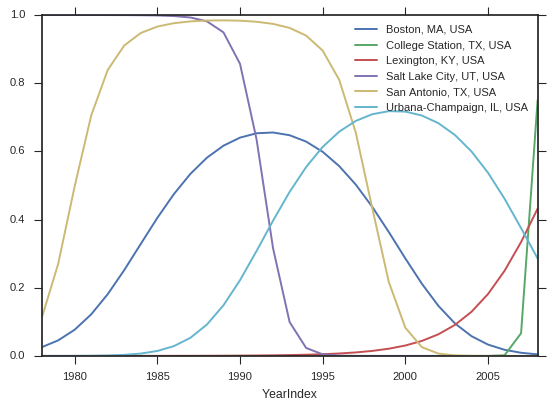

In [16]:
predictions.plot(x="YearIndex")

In [17]:
def fit_models_pos(df, auid):
    data = get_model_data(df, auid)
    models = {}
    first_year = data.Year.min()
    predict_y = pd.DataFrame(np.arange(data.YearIndex.min(), data.YearIndex.max() + 1)[:, np.newaxis], columns=["YearIndex"])
    predictions = predict_y.copy() + first_year
    sample_weight = (data.Weight.values * data.Position.apply(lambda x: 3 if x == 1 else 1).values)
    for c in data.Imputed_City.cat.categories:
        formula = "YearIndex + I(YearIndex**2)"
        clf = Pipeline([
                ("patsy_df", PatsyTransformer(formula, return_type="dataframe")),
                ("clf", LogisticRegression(solver="lbfgs"))
            ])
        clf.fit(data, (data.Imputed_City == c), clf__sample_weight=sample_weight)
        print("%s\tFormula=%s" % (c, formula))
        models[c] = clf
        y_pred = clf.predict_proba(predict_y)[:, 1]
        predictions[c] = y_pred
    return predictions, models

In [18]:
auid = "101462_4"
predictions, models = fit_models_pos(df_filtered, auid)

Boston, MA, USA	Formula=YearIndex + I(YearIndex**2)
College Station, TX, USA	Formula=YearIndex + I(YearIndex**2)
Lexington, KY, USA	Formula=YearIndex + I(YearIndex**2)
Salt Lake City, UT, USA	Formula=YearIndex + I(YearIndex**2)
San Antonio, TX, USA	Formula=YearIndex + I(YearIndex**2)
Urbana-Champaign, IL, USA	Formula=YearIndex + I(YearIndex**2)


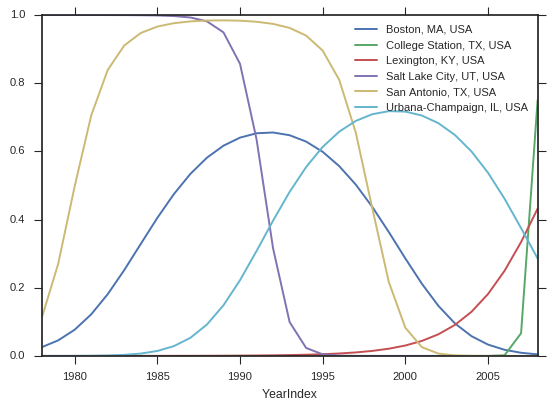

In [19]:
predictions.plot(x="YearIndex")

In [20]:
predictions.head()

,YearIndex,"Boston, MA, USA","College Station, TX, USA","Lexington, KY, USA","Salt Lake City, UT, USA","San Antonio, TX, USA","Urbana-Champaign, IL, USA"
0,1978,0.025507,5.055104e-25,0.000027,0.999864,0.110085,0.000029
1,1979,0.045609,5.391670e-25,0.000035,0.999857,0.269519,0.000082
2,1980,0.076953,6.527332e-25,0.000046,0.999833,0.497576,0.000221
3,1981,0.122009,8.969483e-25,0.000061,0.999786,0.705209,0.000566
4,1982,0.181219,1.399002e-24,0.000080,0.999698,0.838717,0.001378


In [21]:
predictions_indexed = predictions.set_index("YearIndex").idxmax(axis=1)

In [22]:
predictions_indexed.head()

YearIndex
1978    Salt Lake City, UT, USA
1979    Salt Lake City, UT, USA
1980    Salt Lake City, UT, USA
1981    Salt Lake City, UT, USA
1982    Salt Lake City, UT, USA
dtype: object

In [23]:
predictions_indexed.groupby(predictions_indexed).apply(lambda x: (x.index.min(), x.index.max())).reset_index()

,index,0
0,"College Station, TX, USA","(2008, 2008)"
1,"Salt Lake City, UT, USA","(1978, 1987)"
2,"San Antonio, TX, USA","(1988, 1996)"
3,"Urbana-Champaign, IL, USA","(1997, 2007)"
